In [22]:
import os
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.decomposition import PCA
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model

In [15]:
# Define the estrous stages
estrous_stages = ['Anestrus', 'Estrous', 'Diestrus', 'Proestrus']

In [16]:
# Path to the folder containing your local images for each estrous stage
image_folders = ['Database_Deep learning/Anestrus', 'Database_Deep learning/Estrus', 'Database_Deep learning/Diestrus', 'Database_Deep learning/Prestrus']

In [24]:
# Initialize an empty string to store the HTML
image_html = ''

# Iterate through directories and add images to the HTML string
for directory in image_folders:
    random_image = random.choice([f for f in os.listdir(directory) if f.lower().endswith(('.png', '.jpg'))])
    image_path = os.path.join(directory, random_image)
    image_html += f"<img src='{image_path}' width='200' />"

# Display the images in a single line
display(HTML(image_html))


In [17]:
# Initialize lists to store extracted features for each estrous stage
features_lists = []

In [5]:
# Load the pre-trained InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False)
model = Model(inputs=base_model.input, outputs=base_model.get_layer('mixed7').output)

In [18]:
# Process local image files for each estrous stage
for folder in image_folders:
    image_files = [f for f in os.listdir(folder) if f.endswith('.jpg')]
    features_list = []
    for image_file in image_files:
        img_path = os.path.join(folder, image_file)
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        features = model.predict(x)
        features_list.append(features)
    features_lists.append(features_list)

1/1 [==============================] - 0s 48ms/step


In [7]:
# Create a heatmap from the features
features_arrays = [np.vstack(features_list) for features_list in features_lists]

In [8]:
# Combine the features arrays and reshape for PCA
features_array = np.vstack(features_arrays)
features_array = features_array.reshape(-1, features_array.shape[-1])

In [9]:
# Apply PCA to reduce dimensionality
pca = PCA(n_components=4)
features_pca = pca.fit_transform(features_array)

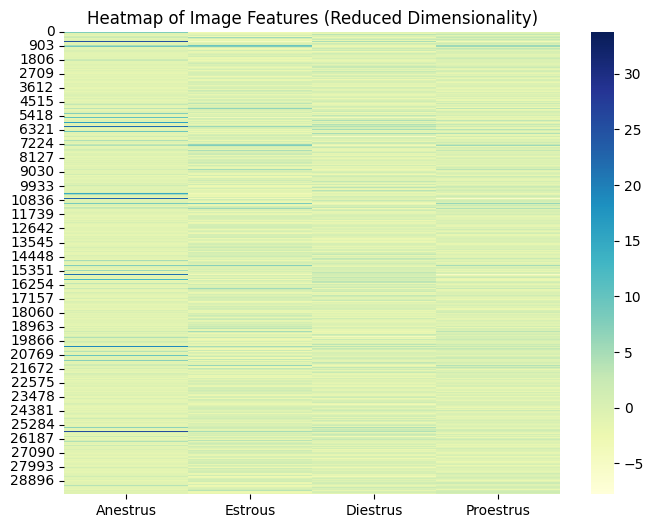

In [10]:
# Display the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(features_pca, annot=False, cmap="YlGnBu", xticklabels=estrous_stages)
plt.title("Heatmap of Image Features (Reduced Dimensionality)")
plt.show()

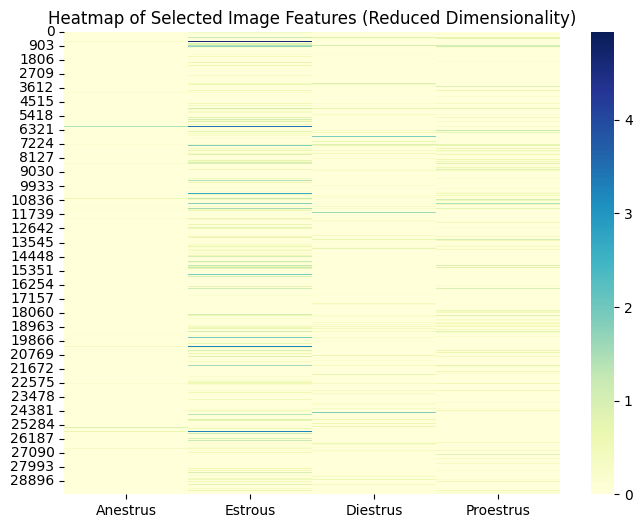

In [21]:
# Binary Wolf Optimization (BWO) for feature selection
def binary_wolf_optimization_feature_selection(features_pca, max_iterations, num_selected_features):
    num_wolves = len(features_pca)
    solution_length = len(features_pca[0])
    
    # Initialize the population with random feature selections
    population = [[random.choice([0, 1]) for _ in range(solution_length)] for _ in range(num_wolves)]
    
    for iteration in range(max_iterations):
        # Evaluate fitness for each wolf's feature selection
        fitness = [sum(population[i]) for i in range(num_wolves)]
        
        # Find the best wolf (with the highest fitness)
        best_wolf_idx = fitness.index(max(fitness))
        
        # Update other wolves based on the best wolf's feature selection
        for i in range(num_wolves):
            if i != best_wolf_idx:
                # Perform a simple binary crossover with the best wolf
                crossover_point = random.randint(0, solution_length - 1)
                population[i][:crossover_point] = population[best_wolf_idx][:crossover_point]
        
    # Select the top 'num_selected_features' features from the best wolf's feature selection
    selected_features = [i for i, val in enumerate(population[best_wolf_idx]) if val == 1][:num_selected_features]
    
    return selected_features

# Number of selected features
num_selected_features = 4

# Apply Binary Wolf Optimization for feature selection
selected_features = binary_wolf_optimization_feature_selection(features_pca, max_iterations=100, num_selected_features=num_selected_features)

# Filter the features array to retain only selected features
selected_features_array = features_array[:, selected_features]

# Create a heatmap from the selected features
plt.figure(figsize=(8, 6))
sns.heatmap(selected_features_array, annot=False, cmap="YlGnBu", xticklabels=estrous_stages)
plt.title("Heatmap of Selected Image Features (Reduced Dimensionality)")
plt.show()
